# Analyzing the apartment rental prices in Prague
{:.no_toc}

> This is a rendered version of a Jupyter notebook. The source notebook can be found [in my GitHub repository](https://github.com/barjin/ndbi023-project), along with the data used in this analysis.

In this data analysis, I tried to understand the apartment rental prices in Prague. The data was collected from the real estate website [Sreality.cz](https://www.sreality.cz/). The data from this source includes the monthly prices, the property sizes, geolocations, and other features. The goal of this analysis is to understand the factors that influence the rental prices of apartments in Prague.

## Contents
{:.no_toc}

1. This is a placeholder for table of contents
{:toc}

## Acquiring the data

This section describes how the data was collected and preprocessed.

### SReality.cz

[Sreality.cz](https://www.sreality.cz/) is a real estate website that lists properties for sale and rent in the Czech Republic. This is the main source of the real estate price data used for this analysis. While the data posted here is probably not legally binding (the prices might be different when the actual contract is signed), it is a good approximation of the real estate prices in the Czech Republic - the best it can be without access to the actual contracts.

More details about the data collection and preprocessing can be found in the [real estate data preprocessing notebook](./sreality_preprocessing.md).

### PID stops

One of the hypotheses I have is that the proximity to the public transportation stops might influence the rental prices. This could go both ways - maybe people are willing to pay more for the convenience of living near a public transportation stop, or maybe the noise and the traffic from the stops might decrease the rental prices. To test this hypothesis, I collected the geolocations of the public transportation stops in Prague. The data was collected from the [PID OpenData](https://pid.cz/en/opendata/) portal.

More details about the data collection and preprocessing can be found in the [traffic data preprocessing notebook](./traffic_preprocessing.md).

### Airbnb listings

Another hypothesis I have is that the rental prices might be influenced by the competition from the short-term rental market. To test this hypothesis, I collected the geolocations of the Airbnb listings in Prague. The data was collected using the [Airbnb Scraper](https://apify.com/tri_angle/airbnb-scraper) on [Apify](https://apify.com/).

More details about the data collection and preprocessing can be found in the [airbnb data preprocessing notebook](./airbnb_preprocessing.md).

### Schools, parks, highways?

I also wanted to collect the geolocations of the schools and other amenities in Prague. For this, I used the [OpenStreetMap](https://www.openstreetmap.org/) data. The data was collected using the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API).

More details about the data collection and preprocessing can be found in the [map data preprocessing notebook](./osm_preprocessing.md).

## First look at the data

We can start with a "sanity check" - let's plot the real estate prices from SReality.cz as a scatter plot onto a "map" of Prague.

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/sreality/index.csv')

plt.ioff()

df.plot(
    kind='scatter', 
    x='locality_gps_lon', 
    y='locality_gps_lat', 
    c="price_summary_czk" , 
    colormap='viridis', 
    s=3, 
    figsize=(15, 10), 
    title="Rental prices per month in Prague, Czech Republic",
    xlabel="Longitude",
    ylabel="Latitude",
).get_figure().savefig('img/sreality/01_rental_prices.png', bbox_inches='tight')

plt.close()

| ![Rental prices per month in Prague, Czech Republic](img/sreality/01_rental_prices.png) |
|:--:|
| *Plotting the rental prices per month with scatterplot on a "map" of Prague* |

> Note that using the geographical coordinates as cartesian coordinates does not map the distances correctly (because the Earth is not flat). However, for small distances (just like in our case here), the error is negligible.
>
> The figure might also be slightly distorted because of the `figsize` used - the aspect ratio is just approximated and might not represent the reality correctly.

Looking at the color scale in the chart above, it seems that some places cost more than 200k CZK a month. 

This is at least suspicious - let's explore that. By sorting the dataset by the price in descending order, we can find the ids of the listings and compose their URLs to the real estate websites to see what's going on.

In [2]:
df.sort_values(
    'price_summary_czk', 
    ascending=False
).head()['hash_id'].astype(int).map(
    lambda x: f'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/{x}'
).values

array(['https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2296964428',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/2434610508',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/1757791564',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/3889546572',
       'https://www.sreality.cz/detail/pronajem/byt/4+kk/abc/238974284'],
      dtype=object)

| ![]( 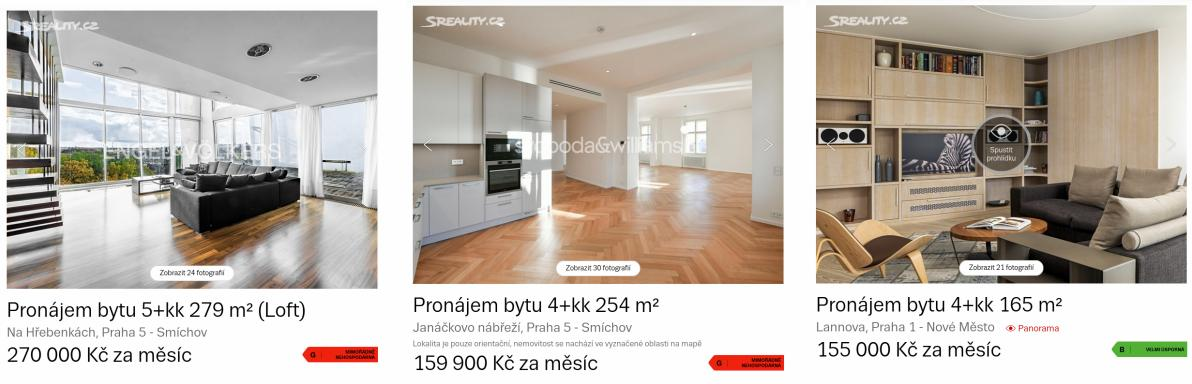) |
|:--:| 
| *Screenshots of the listings from the selection above* |

I stand corrected - these datapoints do not seem to be errorneous, there are just people with much more money than I would expect.

Other than that, the rental data seems (and least from the first glance) to be clean and ready for analysis.

## Location as the culprit?

Without joining the rentals data with any other datasets, we can just look at the location of the properties and see how well it correlates with the rental price.

By using the `staticmap` library, we can generate an actual map of the listings. Let's try to plot the listings on a map of Prague.
To get more variance in the data, we can only plot the listings with a price of 50000 CZK per month or less.

In [3]:
import utils.map_utils as mu

mu.get_map_scale(
    df[df['price_summary_czk'] <= 50000], 
    color_attribute='price_summary_czk', 
    scale_label='Price in CZK / mo', 
    title='Rental prices per month in Prague, Czech Republic'
).savefig(
    'img/sreality/02_rental_prices_map.png', 
    bbox_inches='tight'
)

| ![Map of filtered listing prices](./img/sreality/02_rental_prices_map.png) |
|:--:|
| *Map of filtered listings. Prices are color coded.* |

Unsurprisingly, the priciest listings are located in the areas of Prague 1 and Prague 2, which is the city center.

The total price of the listing might not be the best measure however, as we didn't account for the usable areas of the estate. We can try to plot the price per square meter instead.

In [4]:
df['price_per_sqm'] = df['price_summary_czk'] / df['usable_area']

In [5]:
mu.get_map_scale(
    df[df['price_per_sqm'] < 700], 
    color_attribute='price_per_sqm',
    title='Price per sqm in Prague, Czech Republic'
).savefig(
    'img/sreality/03_price_per_sqm_map.png', 
    bbox_inches='tight'
)

| ![Map of filtered listing prices per square meter](./img/sreality/03_price_per_sqm_map.png) |
|:--:|
| *Map of filtered listings per square meter. Prices are color coded.* |

It really seems that there are certain "high-rent" areas in Prague.

### Training SVM to get the boundaries

To get a better understanding of the locations of the high-rent areas, we can train a Support Vector Machine (SVM) on the data. 

This classifier trains a boundary between the (binary) classes of the data. If we only use the location as the input features (and the price per square meter as the target), we can get a boundary that separates the high-rent areas from the low-rent areas and (more importantly) is easy to visualize as a line (a curve) on the map.

We can use the SVM implementation from `scikit-learn` to do this.

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import sklearn.metrics as metrics

X_train, X_test, y_train, y_test = train_test_split(
    df[['locality_gps_lon', 'locality_gps_lat']], 
    df['price_per_sqm'] > df['price_per_sqm'].median()
)

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', gamma='auto', C=10))
])

pipeline.fit(X_train.to_numpy(), y_train.to_numpy())

pred = pipeline.predict(X_test.to_numpy())

print(metrics.f1_score(y_test, pred))


0.6619859578736209


We managed to train the classifier with F1 score of roughly `0.66`. This is not too good score - perhaps it's hinting at the fact that the price of the listing is not only dependent on the location (or that we might need to tweak the hyperparameters a bit better). 

For now, let's stick with the SVM boundaries and plot them on the map.

In [18]:
import PIL
import urllib
import sklearn.inspection as inspection
import matplotlib
import math

fig, ax = matplotlib.pyplot.subplots(figsize=(15, 15))

image_res = (df["locality_gps_lon"].max() - df["locality_gps_lon"].min(), df["locality_gps_lat"].max() - df["locality_gps_lat"].min())
image_height = 600
image_width = math.floor((image_res[0] / image_res[1]) * image_height)

image = np.array(
    PIL.Image.open(
        urllib.request.urlopen(
            f'https://maps.geoapify.com/v1/staticmap?style=osm-carto&width={image_width}&height={image_height}&area=rect:{df["locality_gps_lon"].min()},{df["locality_gps_lat"].min()},{df["locality_gps_lon"].max()},{df["locality_gps_lat"].max()}&apiKey=d548c5ed24604be6a9dd0d989631f783'
        )
    )
)

ax.imshow(
    image, 
    alpha=1,
    extent=[
        df['locality_gps_lon'].min(), 
        df['locality_gps_lon'].max(), 
        df['locality_gps_lat'].min(), 
        df['locality_gps_lat'].max()
    ],
)

inspection.DecisionBoundaryDisplay.from_estimator(
    pipeline, 
    X_train.to_numpy(), 
    ax=ax, 
    plot_method='contour', 
    grid_resolution=200
)

ax.set_xbound(df['locality_gps_lon'].min(), df['locality_gps_lon'].max())
ax.set_ybound(df['locality_gps_lat'].min(), df['locality_gps_lat'].max())

fig.savefig('img/sreality/04_decision_boundaries.png', bbox_inches='tight')

| ![SVM boundaries](./img/sreality/04_decision_boundaries.png) |
|:--:|
| *Decison boundaries for the trained SVM classifier over the map of Prague. Brighter color signifies higher probability of the listing being in the above-median area.* |

Quite unsurprisingly, this experiment circled out the city center as the most expensive area. On the other hand, the suburbs seem to be classified as below-median areas - the area of Praha-Běchovice and Černý Most stand out the most with the concentration of the boundary lines around them (eastern part of Prague, near the D0 and D11 junction).

Other, less defined below-median areas seem to be around Uhříněves (south-east) and Hostivice (west).

However, we have to keep in mind that the F1 score of the classifier was not too high, so the boundaries might not be as accurate as they seem.

## The number of bathrooms?

While infering the price based on location is a good start, we can try to add more features to the model to get a better understanding of the rental prices.

We start by picking only the numerical features from the dataset and plotting the correlation matrix.

In [42]:
import numpy as np

def get_correlation_matrix(df):
    return df.select_dtypes(
            include=[np.number]
        ).corr(
            'pearson'
        ).dropna(
            axis=1, how='all'
        ).dropna(
            axis=0, how='all'
        )

def get_styled_correlation_matrix(df):
    return df.select_dtypes(
            include=[np.number]
        ).corr(
            'pearson'
        ).dropna(
            axis=1, how='all'
        ).dropna(
            axis=0, how='all'
        ).style.background_gradient(cmap='coolwarm')

get_styled_correlation_matrix(df)

,furnished,object_type,parking_lots,price_summary_unit_cb,locality_street_id,terrace,balcony,locality_district_id,locality_ward_id,loggia,category_sub_cb,building_type,elevator,locality_gps_lat,basin,hash_id,cellar,object_kind,locality_gps_lon,usable_area,locality_quarter_id,ownership,low_energy,easy_access,building_condition,garage,room_count_cb,energy_efficiency_rating_cb,price_summary_czk,price_per_sqm
furnished,1.000000,0.012390,0.048941,0.020874,0.026326,0.048714,0.023594,-0.005182,-0.011873,0.046700,-0.057888,0.031975,0.136664,-0.019640,-0.017012,-0.001443,0.151825,-0.008079,0.051352,0.062009,0.048589,-0.009227,0.000031,0.009252,-0.014038,0.007092,0.017169,0.015294,0.011172,-0.136652
object_type,0.012390,1.000000,0.045411,0.002175,-0.007024,-0.010592,-0.014475,0.001640,-0.027413,-0.007581,-0.008773,0.002071,-0.017437,-0.031238,0.170341,-0.010293,-0.015104,0.707010,0.049041,-0.010601,0.019478,-0.004321,-0.003404,0.040012,-0.015835,0.016839,0.040727,-0.008692,-0.014183,0.009097
parking_lots,0.048941,0.045411,1.000000,-0.018126,0.163429,0.218008,0.144483,-0.056443,-0.027396,0.040438,-0.019992,0.058869,0.012227,-0.013463,0.023921,0.001035,0.197751,0.032106,0.023142,0.147420,0.024042,-0.053266,0.067398,0.014002,0.088997,0.307724,0.104659,-0.059853,0.149195,-0.010493
price_summary_unit_cb,0.020874,0.002175,-0.018126,1.000000,-0.036927,0.001997,0.017060,-0.006309,-0.026089,0.009526,0.018205,-0.007453,-0.040244,-0.004546,0.006354,0.037960,-0.012576,0.001538,-0.005724,-0.000659,-0.016891,-0.009462,0.013454,-0.001226,0.001781,0.003393,-0.081059,-0.034256,-0.031304,-0.048071
locality_street_id,0.026326,-0.007024,0.163429,-0.036927,1.000000,0.046730,0.233897,-0.187445,-0.053610,0.086243,-0.083726,0.137759,0.004224,0.019654,-0.020575,0.014634,0.146665,-0.004957,0.125790,-0.092994,0.098841,-0.004114,0.138075,0.069592,0.122857,0.107388,-0.046416,-0.218403,-0.084004,-0.010832
terrace,0.048714,-0.010592,0.218008,0.001997,0.046730,1.000000,-0.047369,0.008100,-0.025387,-0.025710,0.026176,0.026546,0.033689,0.019405,0.055034,0.005596,0.105406,-0.007489,-0.059357,0.312384,0.007403,-0.047407,0.037641,-0.002241,0.013643,0.196029,0.038886,-0.036768,0.240088,-0.078052
balcony,0.023594,-0.014475,0.144483,0.017060,0.233897,-0.047369,1.000000,-0.069775,-0.045814,-0.003926,-0.023818,0.029547,0.053383,-0.020500,-0.006208,0.005916,0.131137,-0.010234,0.034588,0.114290,0.038721,-0.026322,0.036005,0.015525,-0.003221,0.148383,0.010985,-0.088524,0.110835,-0.065744
locality_district_id,-0.005182,0.001640,-0.056443,-0.006309,-0.187445,0.008100,-0.069775,1.000000,0.371920,-0.005497,0.020224,-0.028874,-0.002156,0.024867,0.004496,0.002196,-0.065135,0.001362,0.009845,0.021823,0.355858,0.012715,0.010616,-0.038429,-0.027133,0.003316,0.016558,0.059979,0.012022,-0.012571
locality_ward_id,-0.011873,-0.027413,-0.027396,-0.026089,-0.053610,-0.025387,-0.045814,0.371920,1.000000,0.005433,-0.023558,-0.013537,-0.018633,0.084567,0.000255,-0.043023,-0.039711,-0.045375,-0.049197,-0.011969,0.193603,-0.021395,-0.008880,-0.018719,0.012754,0.013286,0.029912,0.095790,-0.010695,0.036465
loggia,0.046700,-0.007581,0.040438,0.009526,0.086243,-0.025710,-0.003926,-0.005497,0.005433,1.000000,-0.012897,0.120893,0.045795,-0.002657,0.005401,0.017365,0.128336,-0.005360,0.051354,-0.029325,0.107245,0.040513,0.078716,0.034737,0.013343,0.030779,0.060954,-0.084465,-0.061947,-0.114450


While comprehensive, this correlation matrix is somewhat hard to read - the number of features is quite high and the matrix is quite large.

We can proceed by dropping the `_id` columns - those seem to correlate together (in the case of e.g. `locality_ward_id` and `locality_district_id`), but are not really useful for the analysis.

In [85]:
## From this smaller correlation matrix, we can retrieve the pairs with the highest (absolute value of) correlation

correlation_matrix = get_correlation_matrix(df[[x for x in df.columns.to_list() if not x.endswith('id')]])

# By filling the correlation matrix diagonal with zeros, we can avoid the self-correlation
np.fill_diagonal(correlation_matrix.values, 0)

# We can then unstack the matrix, sort it by the absolute values and retrieve the top 50 pairs - every second row, as the matrix is symmetric
correlation_matrix.unstack().sort_values(ascending=False, key=lambda x: x.abs()).iloc[::2].head(20)

usable_area                  price_summary_czk              0.850885
object_type                  object_kind                    0.707010
usable_area                  terrace                        0.312384
garage                       parking_lots                   0.307724
object_kind                  basin                          0.242001
terrace                      price_summary_czk              0.240088
locality_gps_lat             locality_gps_lon               0.238824
energy_efficiency_rating_cb  easy_access                   -0.234805
garage                       price_summary_czk              0.233140
price_per_sqm                usable_area                   -0.227834
terrace                      parking_lots                   0.218008
usable_area                  garage                         0.207085
energy_efficiency_rating_cb  price_summary_czk              0.200724
cellar                       parking_lots                   0.197751
                             garag

Unsurprisingly, the highest correlation is between the total monthly price of a listing and the usable area of the estate.

Other than that, we can also see some correlation between the existence of garage and the number parking spaces. This is quite logical - if there is a garage, there is a parking space.
In general, the correlation coefficients are quite low, though - this might hint at the fact that the price of the listing is strongly dependent on the usable area.

The largest correlation with the price per square meter is - quite surprisingly - also the `usable_area`. This correlation is negative, though - the larger the area, the lower the price per square meter. This might be due to the fact that the larger estates are located in the suburbs, where the price per square meter is lower. It also doesn't make for a good tip for house hunters - since people are usually on a budget, they might not be able to afford the larger estates.